In [1]:
import os
import rasterio
import numpy as np
import xarray as xr
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
from scripts.utils import IQR_filter


#### 1. data check

In [2]:
dir_save = 'data/dianchi_lake/raster'
path_dianchi_vec = 'data/dianchi_lake/dianchi_vector.gpkg'


In [3]:
## Check original .nc raster file.
paths_file = [os.path.join(dir_save, file) for file in os.listdir(dir_save) if 'Raster_100m_' in file and '.nc' in file]
paths_file = sorted(paths_file)
print(paths_file[5])
raster_nc = xr.open_dataset(paths_file[0])
raster_nc


data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_014_049_099F_20240419T050203_20240419T050224_PIC0_01.nc


<xarray.Dataset>
Dimensions:                  (x: 1501, y: 1500)
Coordinates:
  * x                        (x) float64 1.961e+05 1.962e+05 ... 3.461e+05
  * y                        (y) float64 2.645e+06 2.645e+06 ... 2.795e+06
Data variables: (12/39)
    crs                      object ...
    longitude                (y, x) float64 ...
    latitude                 (y, x) float64 ...
    wse                      (y, x) float32 ...
    wse_qual                 (y, x) float32 ...
    wse_qual_bitwise         (y, x) float64 ...
    ...                       ...
    load_tide_fes            (y, x) float32 ...
    load_tide_got            (y, x) float32 ...
    pole_tide                (y, x) float32 ...
    model_dry_tropo_cor      (y, x) float32 ...
    model_wet_tropo_cor      (y, x) float32 ...
    iono_cor_gim_ka          (y, x) float32 ...
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    institution:                   JPL
    source:                        Ka-band radar interferometer
    history:                       2024-07-16T20:15:39Z : Creation
    platform:                      SWOT
    ...                            ...
    mgrs_latitude_band:            R
    x_min:                         196100.0
    x_max:                         346100.0
    y_min:                         2644900.0
    y_max:                         2794800.0
    product_version:               01

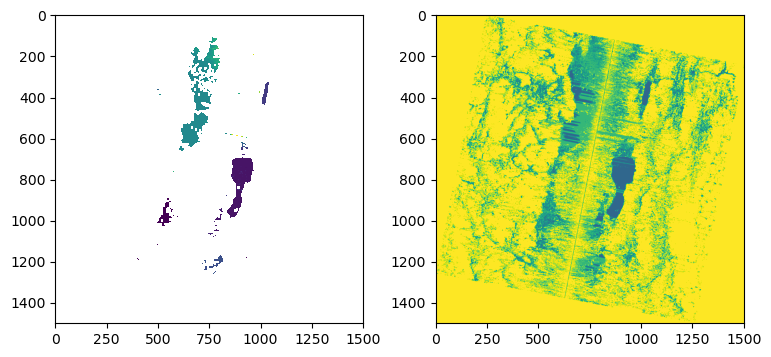

In [4]:
### data check 
wse = np.flip(raster_nc['wse'],  axis=0)
wse_qual = np.flip(raster_nc['wse_qual'], axis=0)
fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(wse, vmax=2100, vmin=1700)
ax[1].imshow(wse_qual, vmin=0, vmax=3)


In [5]:
## get acquisition time information
date_data = [path.split('_')[-4][0:8] for path in paths_file]
date_data = [date[0:4]+'-'+date[4:6]+'-'+date[6:8] for date in date_data]
print(date_data)


['2024-01-05', '2024-01-26', '2024-02-16', '2024-03-08', '2024-03-29', '2024-04-19', '2024-05-10', '2024-05-30', '2024-06-20']


#### 2. data preprocessing
2.1 convert .nc file to .tif file.   
2.2 reproject utm48 to wgs84 projection.   
2.3 layer stacking for .tif files


In [6]:
nc_var = 'wse_qual'
paths_file_tif = [path.replace('.nc', '_'+ nc_var +'.tif') for path in paths_file]
paths_file_wgs84 = [path.replace('.tif', '_wgs84.tif') for path in paths_file_tif]
print(paths_file[0])
print(paths_file_tif[0])
print(paths_file_wgs84[0])


data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_009_049_099F_20240105T211638_20240105T211659_PGC0_01.nc
data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_009_049_099F_20240105T211638_20240105T211659_PGC0_01_wse_qual.tif
data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_009_049_099F_20240105T211638_20240105T211659_PGC0_01_wse_qual_wgs84.tif


In [7]:
# for i, _ in enumerate(paths_file):
#   path_nc, path_tif, path_tif_wgs84 = paths_file[i], paths_file_tif[i], paths_file_wgs84[i]
#   !gdalmdimtranslate \
#       -of "GTiff" \
#       -array $nc_var \
#       -co "COMPRESS=LZW" $path_nc $path_tif

#   !gdalwarp -overwrite \
#       -s_srs EPSG:32648 \
#       -t_srs EPSG:4326 \
#       -r cubic \
#       -co COMPRESS=LZW \
#       -co TILED=YES \
#       $path_tif $path_tif_wgs84


In [8]:
### layer statcking
# path_laysta = dir_save+'/dianchi_'+ nc_var +'_wgs84_laysta.tif'
# _ = lay_stack(path_imgs=paths_file_wgs84, path_out=path_laysta, union=True, res=None)


#### 3. data reading and visualization.

In [9]:
dianchi_gpd = gpd.read_file(path_dianchi_vec)
dianchi_gpd


,Name,geometry
0,dianchi,"POLYGON Z ((102.66614 24.83805 0.00000, 102.65..."


<Axes: >

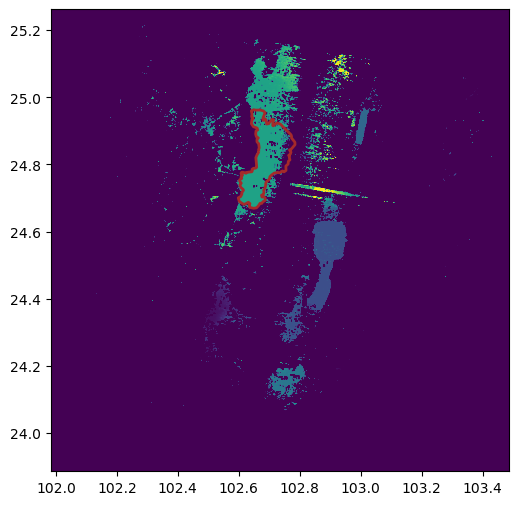

In [10]:
path_laysta_wse = dir_save+'/dianchi_wse_wgs84_laysta.tif'
path_laysta_wse_qual = dir_save+'/dianchi_wse_qual_wgs84_laysta.tif'
src_wse = rasterio.open(path_laysta_wse)
src_wse_qual = rasterio.open(path_laysta_wse_qual)
raster_wse = src_wse.read(6)
fig, ax = plt.subplots(1, figsize=(6,6))
show(raster_wse, ax=ax, vmax=2100, vmin=1600, transform=src_wse.transform)
dianchi_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=2)


In [11]:
### mask out the non-dianchi region.
wse, wse_transform = mask(
    src_wse, 
    dianchi_gpd['geometry'].to_list(), 
    crop=True, 
    nodata=np.nan
)
wse_qual, wse_qual_transform = mask(
    src_wse_qual, 
    dianchi_gpd['geometry'].to_list(), 
    crop=True, 
    nodata=np.nan
)
print(wse.shape)
print(wse_qual.shape)


(9, 312, 198)
(9, 312, 198)


<Axes: title={'center': 'wse'}>

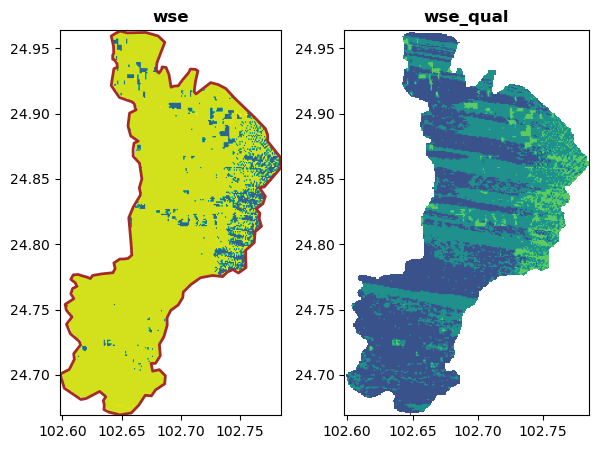

In [12]:
### check the wse and wse_qual image.
id = 0
fig, ax = plt.subplots(1, 2, figsize=(7, 5))
show(wse[id], transform=wse_transform, vmax=2100, vmin=-1000, ax=ax[0], title='wse')
show(wse_qual[id], transform=wse_qual_transform, vmin=0, vmax=4, ax=ax[1], title='wse_qual')
dianchi_gpd.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=2)


### 4. Filtering out the low quality and outlier measurements.
#### 4.1 filtering out the low quality measurements.

In [13]:
wse_qual_high = np.where(wse_qual<=1, wse, np.nan)


#### 4.2 Interquartile Range method for outliers removing.

In [17]:
wse_qual_high_IQR =  np.zeros_like(wse_qual)
for i_band in range(wse_qual_high_IQR.shape[0]):
  wse_qual_high_IQR_, _ = IQR_filter(wse_qual_high[i_band])
  wse_qual_high_IQR[i_band] = wse_qual_high_IQR_.filled(np.nan)


Text(0.5, 1.0, 'high quality and IQR filtered wse')

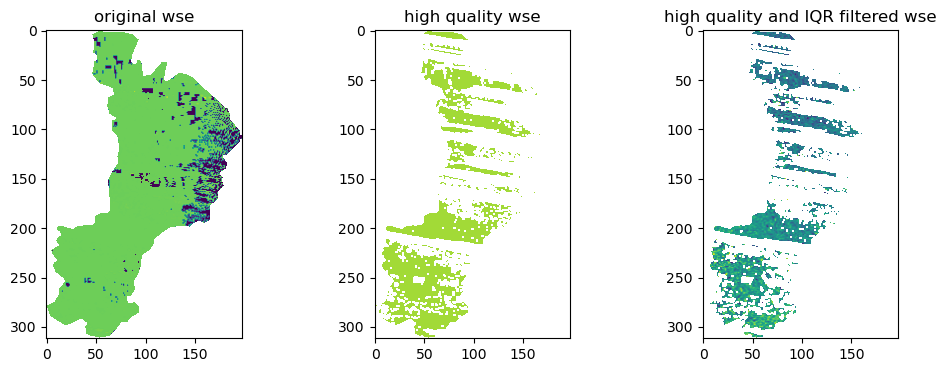

In [18]:
### check the wse, wse_qual image.
id = 0
fig, axes = plt.subplots(1,3,figsize=(12,4))
axes[0].imshow(wse[id])
axes[0].set_title('original wse')
axes[1].imshow(wse_qual_high[id])
axes[1].set_title('high quality wse')
axes[2].imshow(wse_qual_high_IQR[id])
axes[2].set_title('high quality and IQR filtered wse')


### 5. plot the result.

In [19]:
### wse_qual_high
wse_qual_high_mean = np.nanmean(wse_qual_high, axis=(1,2))
print(wse_qual_high_mean)
wse_qual_high_std = np.nanstd(wse_qual_high, axis=(1,2))
print(wse_qual_high_std)
### wse_qual_high_IQR
wse_qual_high_IQR_mean = np.nanmean(wse_qual_high_IQR, axis=(1,2))
wse_qual_high_IQR_std = np.nanstd(wse_qual_high_IQR, axis=(1,2))
print(wse_qual_high_IQR_std)


[1888.063  1888.0441 1888.545  1887.7247 1887.9417 1888.1167 1888.3314
 1887.9635 1887.9279]
[18.086803   5.361577  10.112076   4.553808   6.904278   4.825648
  8.385232   3.1993835  3.3673031]
[0.14332215 0.09031498 0.09544027 0.10161904 0.10035932 0.10002845
 0.10192499 0.11124563 0.11962723]


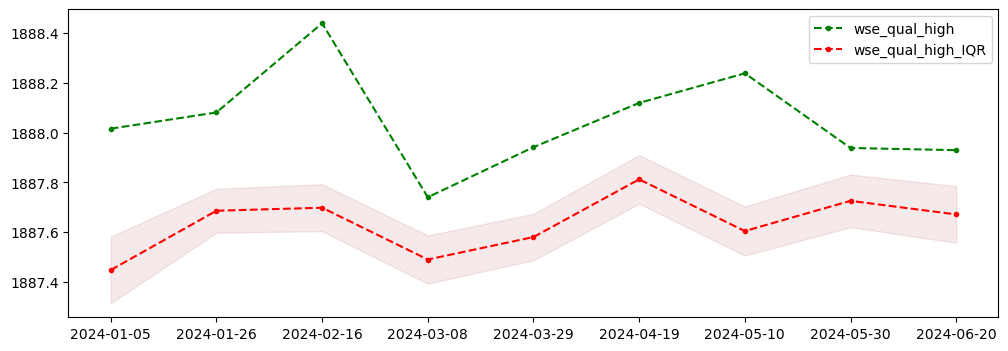

In [19]:
## compare the data filtering with IQR method and without IQR method
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(date_data, wse_qual_high_mean, '--.', color='green', label='wse_qual_high')
ax.plot(date_data, wse_qual_high_IQR_mean, '--.', color='red', label='wse_qual_high_IQR')
ax.fill_between(date_data, wse_qual_high_IQR_mean - wse_qual_high_IQR_std, \
                 wse_qual_high_IQR_mean + wse_qual_high_IQR_std, color='Brown', alpha=0.1)
# ax.fill_between(date_data, wse_qual_high_mean - wse_qual_high_std, \
#                  wse_qual_high_mean + wse_qual_high_std, color='green', alpha=0.1)
ax.legend()


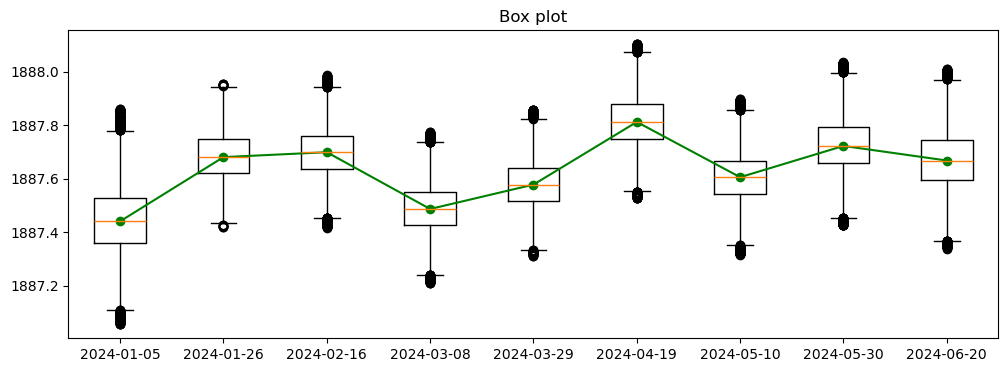

In [18]:
# plot boxplot for swot data.
wse_qual_high_IQR_flatten = [wse_qual_high_IQR[i_band][~np.isnan(wse_qual_high_IQR[i_band])] for i_band in range(wse_qual_high_IQR.shape[0])]
median = [np.nanmedian(wse_qual_high_IQR_flatten[i]) for i in range(len(wse_qual_high_IQR_flatten))]
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.boxplot(wse_qual_high_IQR_flatten)
ax.set_title('Box plot')
ax.set_xticks(np.arange(len(date_data))+1, date_data)
ax.plot(np.arange(len(date_data))+1, median, '-og')
